In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os

import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds
#from keras import backend as K
import tensorflow.keras.backend as K
from keras import layers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D, GlobalAveragePooling2D, Dropout
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.optimizers import Adam 

from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

In [2]:
!nvidia-smi

Thu Apr  7 10:07:59 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

In [ ]:
config =  tf.compat.v1.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.9  # 0.6 sometimes works better for folks
tf.compat.v1.keras.backend.set_session(tf.compat.v1.Session(config=config))

End vision:<br>
- A model that tells you accurately what continent you're on<br>
- A model trained for each continent to distinguish between the countries<br>
- A model trained to tell between all the countries<br>
- A model looking at OCR for language<br>
- A model looking up place names on signs <br>

### Data

In [2]:
img_height, img_width = 640,640
batch_size = 8

In [5]:
directory = "/content/drive/MyDrive/ColabNotebooks/GeoAI/GeoIMAGES/Upload/Asia/Train"
train_ds = tf.keras.utils.image_dataset_from_directory(
    directory, labels='inferred', label_mode='int',
    class_names=None, color_mode='rgb', batch_size=batch_size, image_size=(img_height,img_width), 
    shuffle=True, seed=None, validation_split=None, subset=None,
    interpolation='bilinear', follow_links=False,
    crop_to_aspect_ratio=False
)


directory = "/content/drive/MyDrive/ColabNotebooks/GeoAI/GeoIMAGES/Upload/Asia/Test"
test_ds  = tf.keras.utils.image_dataset_from_directory(
    directory, labels='inferred', label_mode='int',
    class_names=None, color_mode='rgb', batch_size=batch_size, image_size=(img_height,img_width), 
    shuffle=False, seed=None, validation_split=None, subset=None,
    interpolation='bilinear', follow_links=False,
    crop_to_aspect_ratio=False
)

directory = "/content/drive/MyDrive/ColabNotebooks/GeoAI/GeoIMAGES/Upload/Asia/Val"
val_ds  = tf.keras.utils.image_dataset_from_directory(
    directory, labels='inferred', label_mode='int',
    class_names=None, color_mode='rgb', batch_size=batch_size, image_size=(img_height,img_width), 
    shuffle=False, seed=None, validation_split=None, subset=None,
    interpolation='bilinear', follow_links=False,
    crop_to_aspect_ratio=False
)

for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

Found 11129 files belonging to 9 classes.
Found 2320 files belonging to 9 classes.
Found 2238 files belonging to 9 classes.
(8, 640, 640, 3)
(8,)


In [6]:
class_names = train_ds.class_names
print(train_ds.class_names)
print(test_ds.class_names)
print(val_ds.class_names)
num_classes = len(class_names)
num_classes

['BGD', 'IDN', 'KHM', 'KOR', 'LAO', 'LKA', 'MYS', 'PHL', 'THA']
['BGD', 'IDN', 'KHM', 'KOR', 'LAO', 'LKA', 'MYS', 'PHL', 'THA']
['BGD', 'IDN', 'KHM', 'KOR', 'LAO', 'LKA', 'MYS', 'PHL', 'THA']


9

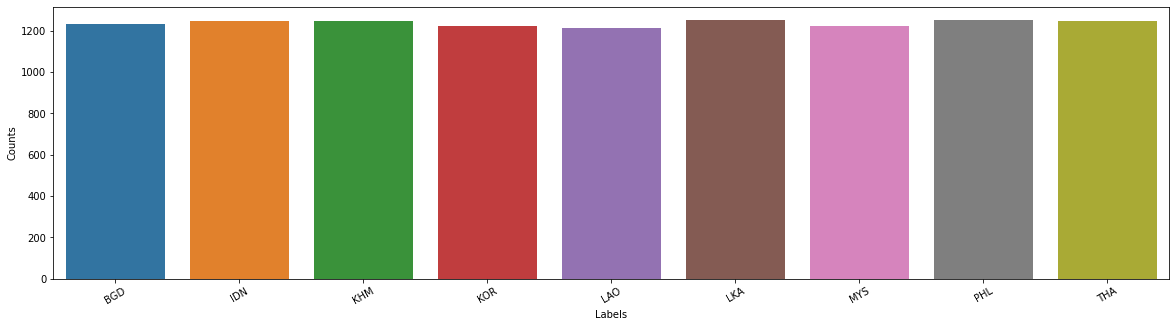

In [5]:
dataset = train_ds
labels = []
for x, y in dataset:
  # Not one hot encoded
  labels.append(y.numpy())

  # If one hot encoded, then apply argmax
  # labels.append(np.argmax(y, axis = -1))
labels = np.concatenate(labels, axis = 0) # Assuming dataset was batched.

unique, counts = np.unique(labels, return_counts=True)
dict(zip(unique, counts))

plt.figure(figsize=(20, 5))
plt.ylabel('Counts')
plt.xlabel('Labels')
plt.xticks(rotation = 30)
sns.barplot(x = class_names, y = counts) 

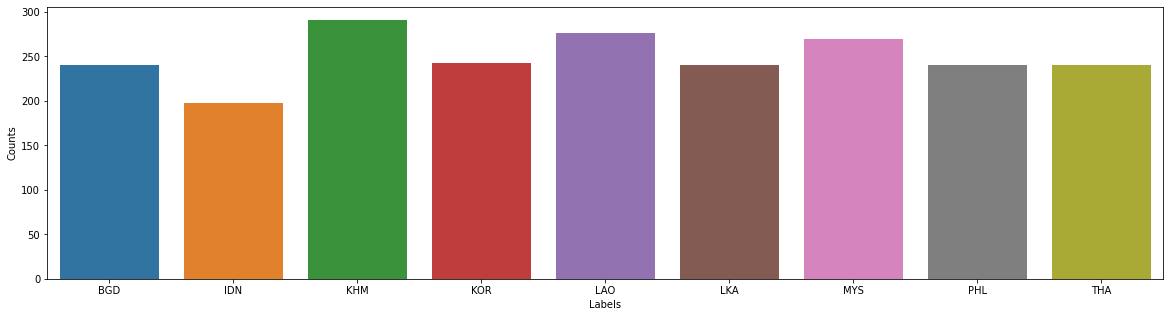

In [6]:
dataset = val_ds
labels = []
for x, y in dataset:
  # Not one hot encoded
  labels.append(y.numpy())

  # If one hot encoded, then apply argmax
  # labels.append(np.argmax(y, axis = -1))
labels = np.concatenate(labels, axis = 0) # Assuming dataset was batched.

unique, counts = np.unique(labels, return_counts=True)
dict(zip(unique, counts))

plt.figure(figsize=(20, 5))
plt.ylabel('Counts')
plt.xlabel('Labels')
plt.xticks([class_names])
sns.barplot(x = class_names, y = counts) 

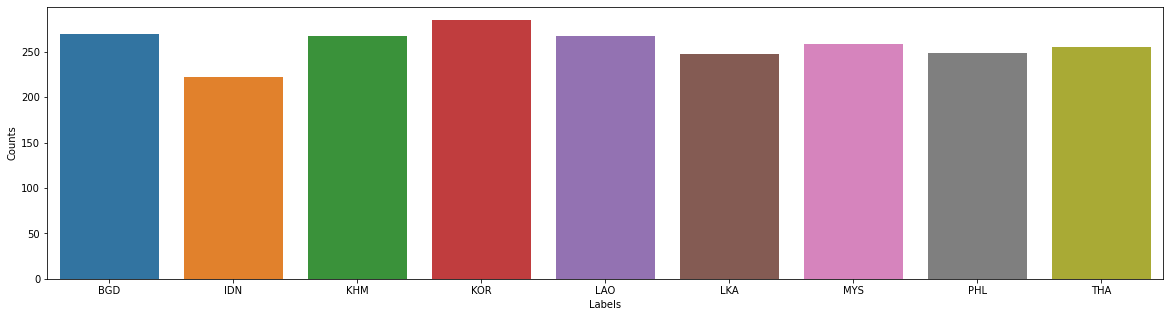

In [7]:
dataset = test_ds
labels = []
for x, y in dataset:
  # Not one hot encoded
  labels.append(y.numpy())

  # If one hot encoded, then apply argmax
  # labels.append(np.argmax(y, axis = -1))
labels = np.concatenate(labels, axis = 0) # Assuming dataset was batched.

unique, counts = np.unique(labels, return_counts=True)
dict(zip(unique, counts))

plt.figure(figsize=(20, 5))
plt.ylabel('Counts')
plt.xlabel('Labels')
plt.xticks([class_names])
sns.barplot(x = class_names, y = counts) 

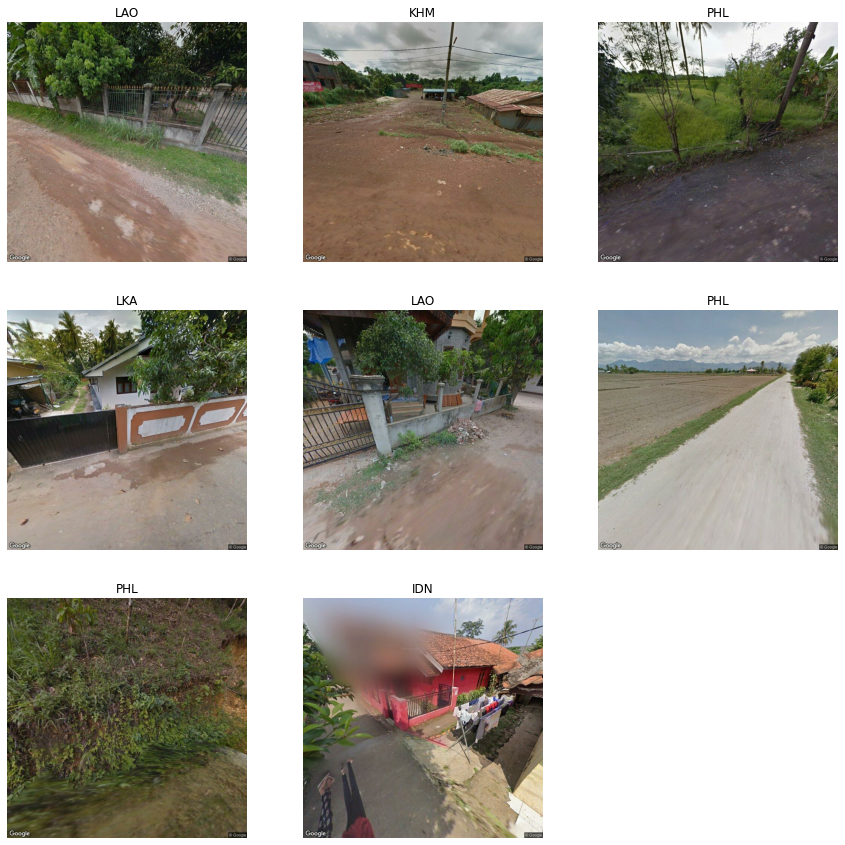

In [9]:
plt.figure(figsize=(15, 15))
for images, labels in train_ds.take(1):
  for i in range(8):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [10]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(8, 640, 640, 3)
(8,)


The image_batch is a tensor of the shape (32, 460,460 3). This is a batch of 32 images of shape 460x460x3 (the last dimension refers to color channels RGB). The label_batch is a tensor of the shape (32,), these are corresponding labels to the 32 images.

You can call .numpy() on either of these tensors to convert them to a numpy.ndarray.

In [11]:
image_batch.numpy().shape

(8, 640, 640, 3)

### Benchmark Keras CNN model

In [ ]:
#normalization_layer = tf.keras.layers.Rescaling(1./255)

In [ ]:
#normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
#image_batch, labels_batch = next(iter(normalized_ds))
#first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
#print(np.min(first_image), np.max(first_image))

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
#num_classes = 4
#img_height, img_width = 320,320#640,640

In [ ]:
K.clear_session()
model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  #tf.keras.layers.Conv2D(32, 3, activation='relu'),
  #tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  #tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])

In [ ]:
model.compile(
  optimizer="adam",#keras.optimizers.Adam(),#,learning_rate=0.001),
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 300, 300, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 298, 298, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 149, 149, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 147, 147, 32)      9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 73, 73, 32)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 170528)            0

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)

In [ ]:
import tensorflow as tf
import gc

class MyCustomCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    gc.collect()

In [ ]:
epochs = 5
history=model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=[callback]#MyCustomCallback()]
)

Epoch 1/5
1766/1766 [==============================] - 48s 27ms/step - loss: 2.3410 - accuracy: 0.1612 - val_loss: 2.2230 - val_accuracy: 0.2039
Epoch 2/5
1766/1766 [==============================] - 29s 16ms/step - loss: 1.9534 - accuracy: 0.3212 - val_loss: 2.1824 - val_accuracy: 0.2626
Epoch 3/5
1766/1766 [==============================] - 29s 16ms/step - loss: 1.1167 - accuracy: 0.6248 - val_loss: 2.7524 - val_accuracy: 0.2891
Epoch 4/5
1766/1766 [==============================] - 29s 16ms/step - loss: 0.4593 - accuracy: 0.8550 - val_loss: 4.5053 - val_accuracy: 0.2971
Epoch 5/5
1766/1766 [==============================] - 29s 16ms/step - loss: 0.2069 - accuracy: 0.9386 - val_loss: 5.4781 - val_accuracy: 0.3045


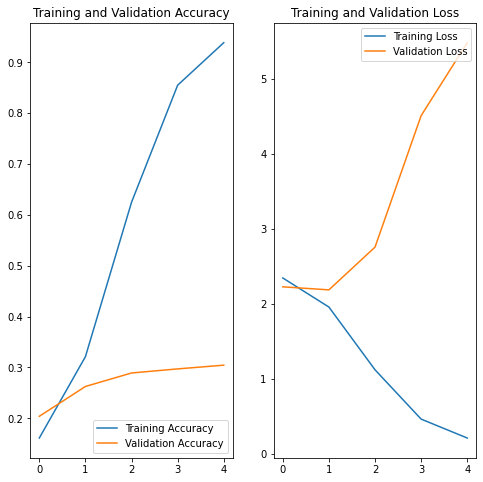

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
result = model.evaluate(test_ds)
dict(zip(model.metrics_names, result))

320/320 [==============================] - 7s 21ms/step - loss: 6.9543 - accuracy: 0.1667


{'accuracy': 0.1666666716337204, 'loss': 6.954262733459473}

In [ ]:
y_pred = model.predict(test_ds)
predicted_categories = tf.argmax(y_pred, axis=1)
true_categories = tf.concat([y for x, y in test_ds], axis=0)
confmx = confusion_matrix( true_categories,predicted_categories) #suppsed to be y_test, y_pred

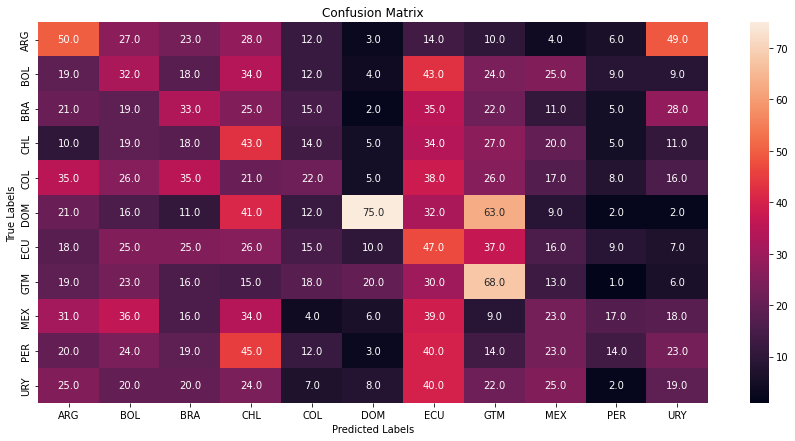

In [ ]:
f, ax = plt.subplots(figsize = (15,7))
sns.heatmap(confmx, annot=True, fmt='.1f', ax = ax)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')

xlabels = [item.get_text() for item in ax.get_xticklabels()]
ylabels = [item.get_text() for item in ax.get_yticklabels()]

for c,i in enumerate(class_names):
  xlabels[c] = i
  ylabels[c] = i
  
ax.set_xticklabels(xlabels)
ax.set_yticklabels(ylabels)

plt.show();

In [ ]:
print(classification_report( true_categories,predicted_categories, target_names= class_names))

              precision    recall  f1-score   support

         ARG       0.19      0.22      0.20       226
         BOL       0.12      0.14      0.13       229
         BRA       0.14      0.15      0.15       216
         CHL       0.13      0.21      0.16       206
         COL       0.15      0.09      0.11       249
         DOM       0.53      0.26      0.35       284
         ECU       0.12      0.20      0.15       235
         GTM       0.21      0.30      0.25       229
         MEX       0.12      0.10      0.11       233
         PER       0.18      0.06      0.09       237
         URY       0.10      0.09      0.10       212

    accuracy                           0.17      2556
   macro avg       0.18      0.17      0.16      2556
weighted avg       0.19      0.17      0.17      2556



In [ ]:
#predicting

In [ ]:
path =  "/content/drive/MyDrive/ColabNotebooks/GeoAI/GeoIMAGES/Upload/Test/ZAF/ZAF#-25.0#29.65#240.jpg"

plt.figure(figsize=(5, 5))
img=mpimg.imread(path)
imgplot = plt.imshow(img)
plt.axis("off")
plt.show()

img = tf.keras.utils.load_img(
    path, target_size=(img_height, img_width)
)

img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

#for i, sc in enumerate(score):
  
 # print("class: ", class_names[i])
  #print("score: ", 100 * np.max(sc) )
  

### Xception model


#### Train

In [12]:
num_classes

9

In [ ]:
def get_model(size= (640,640,3), num_classes=4):

  base_model = keras.applications.Xception(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=size,
    include_top=False)  # Do not include the ImageNet classifier at the top.

  base_model.trainable = False
  inputs = keras.Input(shape=size)

  x = keras.applications.xception.preprocess_input(inputs)
  x = keras.layers.experimental.preprocessing.RandomFlip("horizontal")(x)
  x = keras.layers.experimental.preprocessing.RandomZoom((-0.15,0.0),None, "reflect")(x)

  
  x = base_model(x, training=False)
  # Convert features of shape `base_model.output_shape[1:]` to vectors
  x = keras.layers.Conv2D(512,4,2)(x)
  x = keras.layers.BatchNormalization()(x)
  x = keras.layers.ReLU()(x)
  x = keras.layers.Conv2D(512,4,2)(x)
  x = keras.layers.GlobalAveragePooling2D()(x)
  x = keras.layers.Dropout(0.2)(x) 
  x = keras.layers.BatchNormalization()(x)
  x = keras.layers.ReLU()(x)
 # Regularize with dropout
  x = keras.layers.Conv2D(num_classes,3,1)(x) 

  ####


  outputs = keras.layers.Flatten()(x)

  model = keras.Model(inputs, outputs)

  model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[keras.metrics.SparseCategoricalAccuracy()])

  return model


In [10]:
size = (img_height,img_width,3)

num_classes = len(class_names)

K.clear_session()

base_model = keras.applications.Xception(
  weights='imagenet',  # Load weights pre-trained on ImageNet.
  input_shape=size,
  include_top=False)  # Do not include the ImageNet classifier at the top.

base_model.trainable = False
inputs = keras.Input(shape=size)

x = keras.applications.xception.preprocess_input(inputs)
x = keras.layers.experimental.preprocessing.RandomFlip("horizontal")(x)
x = keras.layers.experimental.preprocessing.RandomZoom((-0.15,0.0),None, "reflect")(x)

x = base_model(x, training=False)
# Convert features of shape `base_model.output_shape[1:]` to vectors
x = keras.layers.Conv2D(512,4,2)(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.ReLU()(x)
x = keras.layers.Dropout(0.2)(x)
x = keras.layers.Conv2D(512,4,2)(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.ReLU()(x)
x = keras.layers.Dropout(0.2)(x)
x = keras.layers.Conv2D(num_classes,3,1)(x)


outputs = keras.layers.Flatten()(x)

83697664/83683744 [==============================] - 0s 0us/step


In [11]:
model = keras.Model(inputs, outputs)

model.compile(
  optimizer=keras.optimizers.Adam(),
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=[keras.metrics.SparseCategoricalAccuracy()])

In [12]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 640, 640, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 640, 640, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 640, 640, 3)      0         
 a)                                                              
                                                                 
 random_flip (RandomFlip)    (None, 640, 640, 3)       0         
                                                                 
 random_zoom (RandomZoom)    (None, 640, 640, 3)       0         
                                                                 
 xception (Functional)       (None, 20, 20, 2048)      208614

In [13]:
epochs = 10
#num_classes = 4

history = model.fit(train_ds, epochs=epochs,  validation_data= val_ds,
                    callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_sparse_categorical_accuracy', patience=3)])

Epoch 1/10
1392/1392 [==============================] - 2580s 2s/step - loss: 2.0727 - sparse_categorical_accuracy: 0.3610 - val_loss: 1.8623 - val_sparse_categorical_accuracy: 0.3928
Epoch 2/10
1392/1392 [==============================] - 328s 236ms/step - loss: 1.4052 - sparse_categorical_accuracy: 0.5227 - val_loss: 1.7640 - val_sparse_categorical_accuracy: 0.4383
Epoch 3/10
1392/1392 [==============================] - 328s 236ms/step - loss: 1.1586 - sparse_categorical_accuracy: 0.6011 - val_loss: 1.5697 - val_sparse_categorical_accuracy: 0.4656
Epoch 4/10
1392/1392 [==============================] - 328s 236ms/step - loss: 1.0089 - sparse_categorical_accuracy: 0.6512 - val_loss: 1.5536 - val_sparse_categorical_accuracy: 0.5009
Epoch 5/10
1392/1392 [==============================] - 329s 237ms/step - loss: 0.8716 - sparse_categorical_accuracy: 0.7000 - val_loss: 1.9766 - val_sparse_categorical_accuracy: 0.4468
Epoch 6/10
1392/1392 [==============================] - 329s 236ms/step 

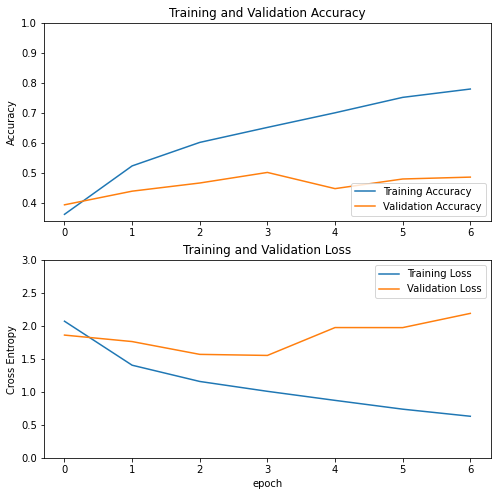

In [14]:
acc = history.history['sparse_categorical_accuracy']
val_acc = history.history['val_sparse_categorical_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,3])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [15]:
# Get model (Sequential, Functional Model, or Model subclass)
model.save("/content/drive/MyDrive/ColabNotebooks/GeoAI/xception_Asia.h5")

#### Evaluate

In [ ]:
from tensorflow import keras
model = keras.models.load_model("/content/drive/MyDrive/ColabNotebooks/GeoAI/xception_SouthAmerica.h5")

In [16]:
result = model.evaluate(test_ds)
dict(zip(model.metrics_names, result))

290/290 [==============================] - 434s 1s/step - loss: 1.6204 - sparse_categorical_accuracy: 0.5586


{'loss': 1.6204241514205933, 'sparse_categorical_accuracy': 0.5586206912994385}

In [17]:
y_pred = model.predict(test_ds)
predicted_categories = tf.argmax(y_pred, axis=1)
true_categories = tf.concat([y for x, y in test_ds], axis=0)
confmx = confusion_matrix( true_categories,predicted_categories) #suppsed to be y_test, y_pred

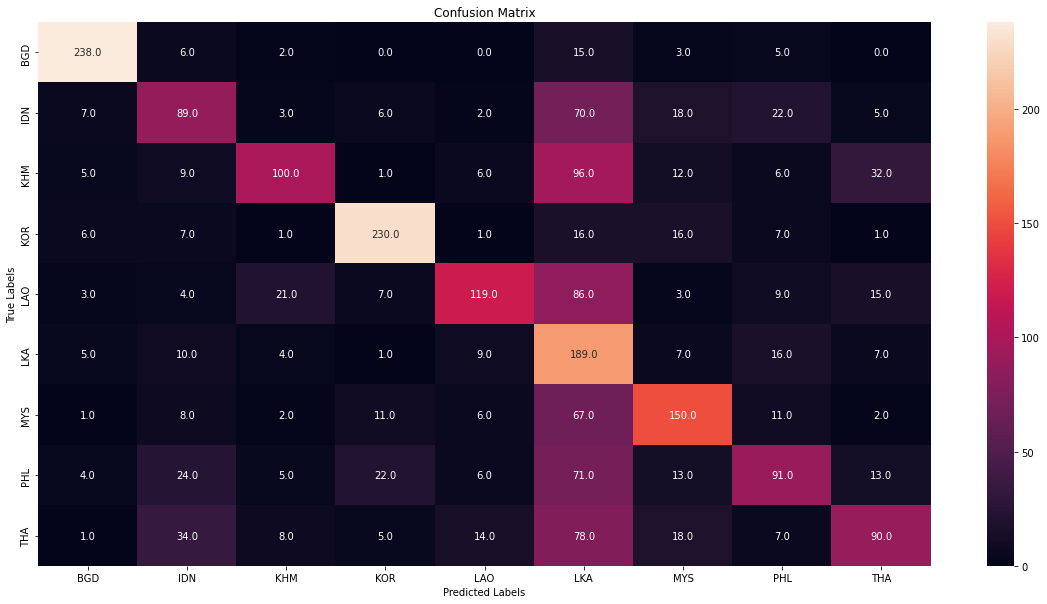

In [18]:
f, ax = plt.subplots(figsize = (20,10))
sns.heatmap(confmx, annot=True, fmt='.1f', ax = ax)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')

xlabels = [item.get_text() for item in ax.get_xticklabels()]
ylabels = [item.get_text() for item in ax.get_yticklabels()]

for c,i in enumerate(class_names):
  xlabels[c] = i
  ylabels[c] = i
  
ax.set_xticklabels(xlabels)
ax.set_yticklabels(ylabels)

plt.show();

In [19]:
print(classification_report(true_categories,predicted_categories,  target_names= class_names))

              precision    recall  f1-score   support

         BGD       0.88      0.88      0.88       269
         IDN       0.47      0.40      0.43       222
         KHM       0.68      0.37      0.48       267
         KOR       0.81      0.81      0.81       285
         LAO       0.73      0.45      0.55       267
         LKA       0.27      0.76      0.40       248
         MYS       0.62      0.58      0.60       258
         PHL       0.52      0.37      0.43       249
         THA       0.55      0.35      0.43       255

    accuracy                           0.56      2320
   macro avg       0.62      0.55      0.56      2320
weighted avg       0.62      0.56      0.57      2320



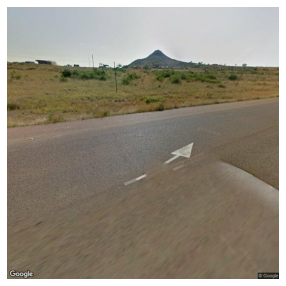

This image most likely belongs to SWZ with a 99.52% confidence.


In [ ]:
img_height, img_width = 640,640

path =  "/content/drive/MyDrive/ColabNotebooks/GeoAI/GeoIMAGES/Upload/AfricaMiddleEast/Test/SWZ/SWZ#-27.20138#31.630645#0.jpg"
plt.figure(figsize=(5, 5))
img=mpimg.imread(path)
imgplot = plt.imshow(img)
plt.axis("off")
plt.show()

img = tf.keras.utils.load_img(
    path, target_size=(img_height, img_width)
)

img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f}% confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

In [ ]:
''' 

test_ds

X_test = []
y_test = []
for image_batch, labels_batch in test_ds:

  for image in image_batch:

    X_test.append(image)

  for label in labels_batch:
    y_test.append(label)

X_test = np.array(X_test)
y_test = np.array(y_test)

y_pred = model2.predict(np.array(X_test))

# Converting prediction classes from one hot encoding to list
# Argmax returns the position of the largest value
y_pred_classes = np.argmax(y_pred, axis = 1)

y_test_classes = y_test


# Create the confusion matrix
confmx = confusion_matrix(y_test_classes, y_pred_classes)
f, ax = plt.subplots(figsize = (8,8))
sns.heatmap(confmx, annot=True, fmt='.1f', ax = ax)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show();
'''

#### Fine tune

In [ ]:
base_model = keras.applications.Xception(
  weights='imagenet',  # Load weights pre-trained on ImageNet.
  input_shape=(640,640,3),
  include_top=False)

83697664/83683744 [==============================] - 2s 0us/step


In [ ]:
model = keras.models.load_model("/content/drive/MyDrive/ColabNotebooks/GeoAI/xception_Europe.h5")

In [20]:
base_model.trainable = True
base_learning_rate = 0.0001

In [21]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  132


In [22]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.Adam(learning_rate=base_learning_rate/10),
              metrics=[keras.metrics.SparseCategoricalAccuracy()])

#optimizer=keras.optimizers.Adam(),
#    loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
#    metrics=[keras.metrics.SparseCategoricalAccuracy()]

In [23]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 640, 640, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 640, 640, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 640, 640, 3)      0         
 a)                                                              
                                                                 
 random_flip (RandomFlip)    (None, 640, 640, 3)       0         
                                                                 
 random_zoom (RandomZoom)    (None, 640, 640, 3)       0         
                                                                 
 xception (Functional)       (None, 20, 20, 2048)      208614

In [24]:
len(model.trainable_variables)

49

In [25]:
initial_epochs = 10
loss0, accuracy0 = model.evaluate(test_ds)

290/290 [==============================] - 55s 186ms/step - loss: 1.6204 - sparse_categorical_accuracy: 0.5586


In [26]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 1.62
initial accuracy: 0.56


In [27]:
history = model.fit(train_ds,
                    epochs=10,
                    validation_data=val_ds)

Epoch 1/10
1392/1392 [==============================] - 472s 337ms/step - loss: 0.3951 - sparse_categorical_accuracy: 0.8654 - val_loss: 1.6228 - val_sparse_categorical_accuracy: 0.5755
Epoch 2/10
1392/1392 [==============================] - 470s 338ms/step - loss: 0.3116 - sparse_categorical_accuracy: 0.8911 - val_loss: 1.6155 - val_sparse_categorical_accuracy: 0.5853
Epoch 3/10
1392/1392 [==============================] - 470s 338ms/step - loss: 0.2530 - sparse_categorical_accuracy: 0.9122 - val_loss: 1.5818 - val_sparse_categorical_accuracy: 0.5885
Epoch 4/10
1392/1392 [==============================] - 470s 337ms/step - loss: 0.2125 - sparse_categorical_accuracy: 0.9277 - val_loss: 1.6447 - val_sparse_categorical_accuracy: 0.5853
Epoch 5/10
1392/1392 [==============================] - 470s 338ms/step - loss: 0.1781 - sparse_categorical_accuracy: 0.9407 - val_loss: 1.7610 - val_sparse_categorical_accuracy: 0.5782
Epoch 6/10
1392/1392 [==============================] - 470s 338ms/ste

In [29]:
# Get model (Sequential, Functional Model, or Model subclass)
model.save("/content/drive/MyDrive/ColabNotebooks/GeoAI/xception_Asia_finetuned.h5")

In [ ]:
model = keras.models.load_model("/content/drive/MyDrive/ColabNotebooks/GeoAI/xception_Europe_half_finetuned.h5")

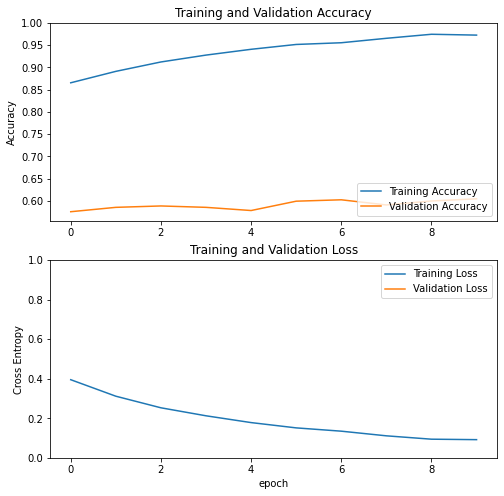

In [30]:
acc = history.history['sparse_categorical_accuracy']
val_acc = history.history['val_sparse_categorical_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [33]:
result = model.evaluate(test_ds)
dict(zip(model.metrics_names, result))

290/290 [==============================] - 54s 185ms/step - loss: 1.4307 - sparse_categorical_accuracy: 0.6707


{'loss': 1.430655837059021, 'sparse_categorical_accuracy': 0.6706896424293518}

In [34]:
y_pred = model.predict(test_ds)

In [36]:
predicted_categories = tf.argmax(y_pred, axis=1)
true_categories = tf.concat([y for x, y in test_ds], axis=0)
confmx = confusion_matrix(true_categories,predicted_categories, )

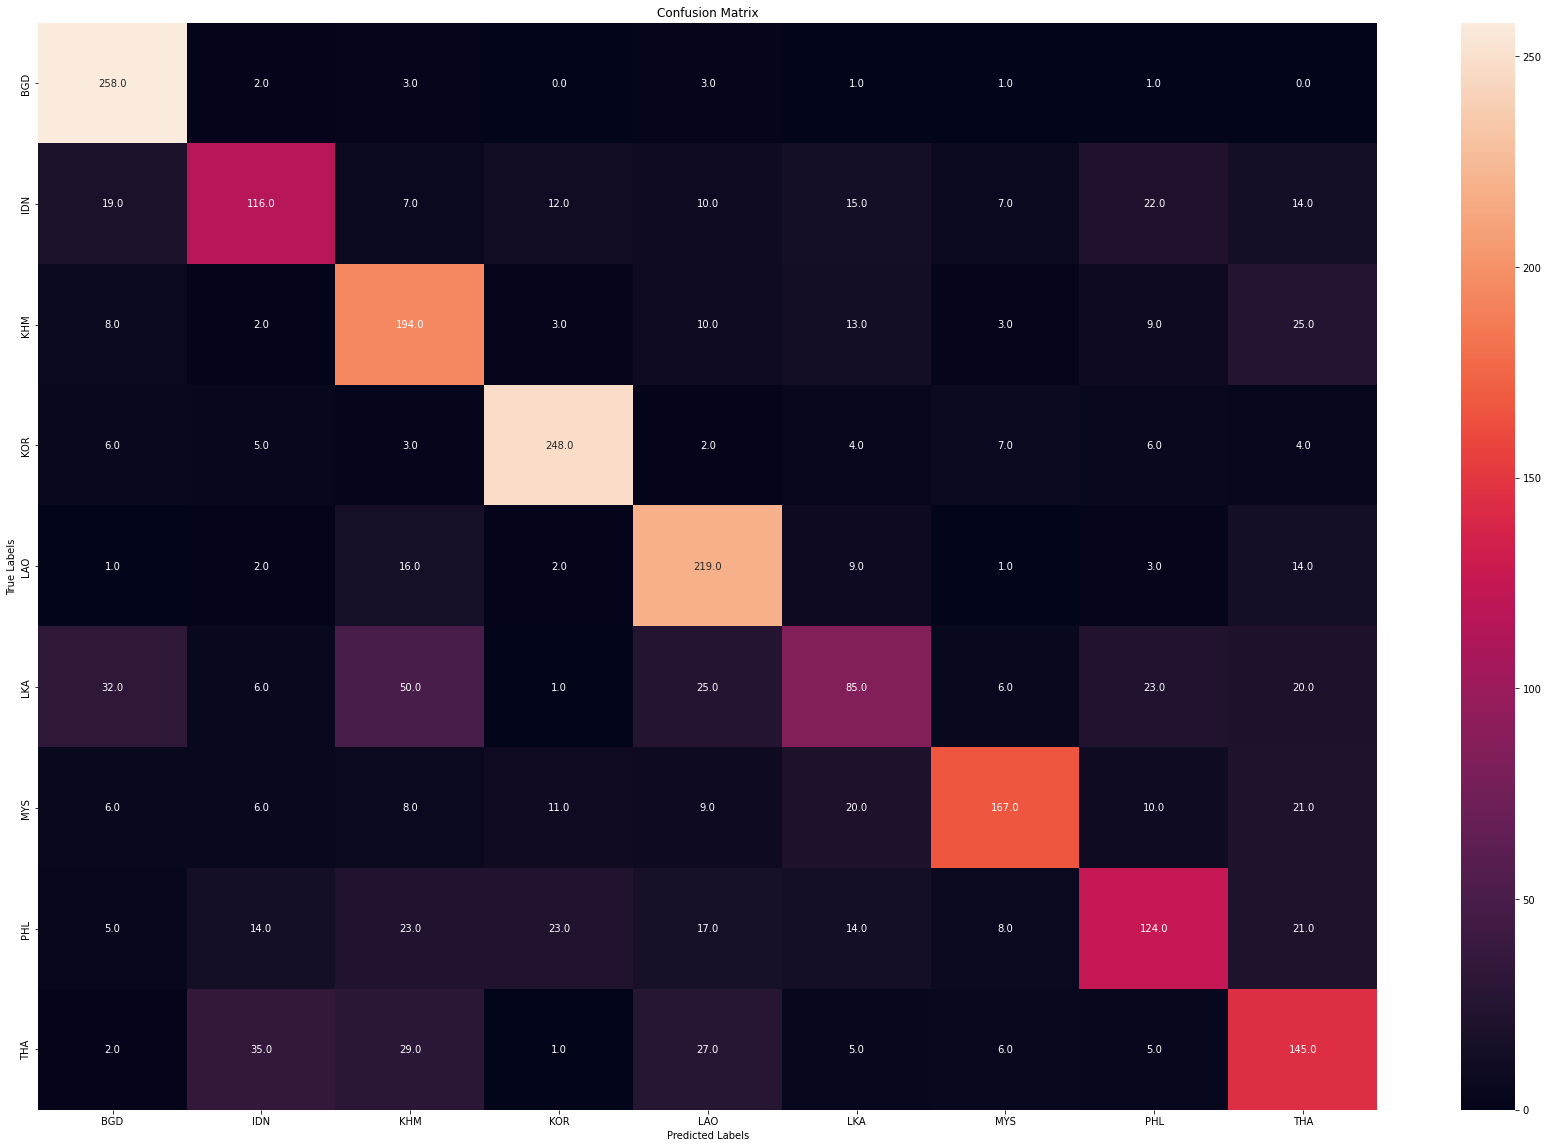

In [37]:
f, ax = plt.subplots(figsize = (30,20))
sns.heatmap(confmx, annot=True, fmt='.1f', ax = ax)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')

xlabels = [item.get_text() for item in ax.get_xticklabels()]
ylabels = [item.get_text() for item in ax.get_yticklabels()]

for c,i in enumerate(class_names):
  xlabels[c] = i
  ylabels[c] = i
  
ax.set_xticklabels(xlabels)
ax.set_yticklabels(ylabels)

plt.show();

In [38]:
print(classification_report( true_categories,predicted_categories, target_names= class_names))

              precision    recall  f1-score   support

         BGD       0.77      0.96      0.85       269
         IDN       0.62      0.52      0.57       222
         KHM       0.58      0.73      0.65       267
         KOR       0.82      0.87      0.85       285
         LAO       0.68      0.82      0.74       267
         LKA       0.51      0.34      0.41       248
         MYS       0.81      0.65      0.72       258
         PHL       0.61      0.50      0.55       249
         THA       0.55      0.57      0.56       255

    accuracy                           0.67      2320
   macro avg       0.66      0.66      0.65      2320
weighted avg       0.67      0.67      0.66      2320



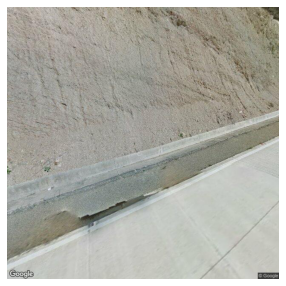

This image most likely belongs to PHL with a 98.83% confidence.


In [39]:
img_height, img_width = 640,640

path =  "/content/drive/MyDrive/ColabNotebooks/GeoAI/GeoIMAGES/Upload/SouthAmerica/Test/BOL/BOL#-19.06326#-64.75864#240.jpg"
plt.figure(figsize=(5, 5))
img=mpimg.imread(path)
imgplot = plt.imshow(img)
plt.axis("off")
plt.show()

img = tf.keras.utils.load_img(
    path, target_size=(img_height, img_width)
)

img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f}% confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)